In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

# Insert mavenn at beginning of path
import sys
path_to_mavenn_local = '../../'
sys.path.insert(0,path_to_mavenn_local)
path_to_suftware_local = '../../../suftware/'
sys.path.insert(0,path_to_suftware_local)

# Load mavenn and check path
import mavenn
print(mavenn.__path__)

# Load suftware and check path
import suftware
print(suftware.__file__)

# MAVE-NN utilities
from mavenn.src.entropy import entropy_continuous

# Useful constants
pi = np.pi
e = np.exp(1)

['../../mavenn']
../../../suftware/suftware.py


In [2]:
# Load GB1 data
data_df = mavenn.load_example_dataset('mpsa')

# Compute length and preview df
N = len(data_df)
print(f'N: {N:,}')
data_df.head()

N: 30490


,training_set,tot_ct,ex_ct,y,x
0,True,1588,66,-4.567814,ACGGUCCAU
1,True,1533,118,-3.688265,AUUGCCAGG
2,True,1459,399,-1.867896,ACAGCGGUA
3,True,1414,246,-2.518219,AACGCCAGG
4,True,1412,60,-4.533808,ACGGCUUGG


In [3]:
# Select N_sub sequences to estimate intrinsic information on
N_sub = 10000
ix = np.random.choice(N, size=N_sub, replace=False)
sub_df = data_df.iloc[ix].copy().reset_index(drop=True)
sub_df.head()

,training_set,tot_ct,ex_ct,y,x
0,True,116,7,-3.870365,GUGGCGAUA
1,True,815,23,-5.087463,ACUGCCUGU
2,True,22,0,-4.523562,GACGUAGUG
3,True,149,14,-3.321928,GUGGCUCAG
4,True,150,10,-3.778973,CCAGUGGAC


In [4]:
# Set number of bootstrap samples

# Extract counts
i_n = sub_df['tot_ct'].values
o_n = sub_df['ex_ct'].values
r_n = (o_n+1)/(i_n+1)
y_n = np.log2(r_n)

# Resample counts
K = 1000
fudge = 0.1
mu_i_nk = np.random.choice(a=i_n, size=[N_sub,K], replace=True)
mu_o_nk = r_n[:,np.newaxis] * mu_i_nk
i_nk = np.random.poisson(lam=mu_i_nk)
o_nk = np.random.poisson(lam=mu_o_nk)
r_nk = (o_nk+1)/(i_nk+1)
y_nk = np.log2(r_nk)

In [5]:
# Compute naive estimate
dy2_naive_n = (np.log2(e)**2)*(1./(o_n+1.) + 1./(i_n+1))
H_n_naive = 0.5*np.log2(2*pi*e*dy2_naive_n)
H_ygx_naive = np.mean(H_n_naive)
dH_ygx_naive = np.std(H_n_naive)/np.sqrt(N_sub)
print(f'H[y|x] (naive): {H_ygx_naive:.4f} +- {dH_ygx_naive:.4f} bits')

H[y|x] (naive): 1.1745 +- 0.0090 bits


In [6]:
# Estaimte entropy using Gaussian approx
dy2_n = np.var(y_nk, axis=1)
H_n_gauss = 0.5*np.log2(2*pi*e*dy2_n)
H_ygx_gauss = np.mean(H_n_gauss)
dH_ygx_gauss = np.std(H_n_gauss)/np.sqrt(N_sub)
print(f'H[y|x] (gauss): {H_ygx_gauss:.4f} +- {dH_ygx_gauss:.4f} bits')

H[y|x] (gauss): 1.2873 +- 0.0047 bits


In [7]:
# Estimate gamma using interquartile range
q25_n = np.quantile(y_nk, q=.25, axis=1)
q75_n = np.quantile(y_nk, q=.75, axis=1)
gamma_n = 0.5*(q75_n-q25_n)
H_n = np.log2(4*np.pi*gamma_n)
H_ygx_cauchy = np.mean(H_n)
dH_ygx_cauchy = np.std(H_n)/np.sqrt(N_sub)
print(f'H[y|x] (cauchy): {H_ygx_cauchy:.4f} +- {dH_ygx_cauchy:.4f} bits')

H[y|x] (cauchy): 2.0155 +- 0.0056 bits


In [8]:
# Estimate entropy using knn
H_n_knn = np.zeros(N_sub)
for i in range(N_sub):
    y_k = y_nk[i,:].copy()
    y_k += np.std(y_k)*.01*np.random.randn(K)
    H_n_knn[i] = entropy_continuous(y_k, knn=5, uncertainty=False)
    
H_ygx_knn = np.mean(H_n_knn)
dH_ygx_knn = np.std(H_n_knn)/np.sqrt(N_sub)
print(f'H[y|x] (knn): {H_ygx_knn:.4f} +- {dH_ygx_knn:.4f} bits')

H[y|x] (knn): 1.1824 +- 0.0049 bits


In [9]:
import warnings
warnings.filterwarnings("ignore")

# Estimate entropy using deft
N_deft = 300
H_n_deft = np.ones(N_deft)*np.nan
for i in range(N_deft):
    y_k = y_nk[i,:]
    try:
        est = suftware.DensityEstimator(y_k, num_posterior_samples=0)
        print('.', end='')
        if i%100==99:
            print(i+1)
    except SystemExit:
        print('x', end='')
    stats_df = est.get_stats(use_weights=False)
    H_n_deft[i] = stats_df.loc['star','entropy']
        
ix = np.isfinite(H_n_deft)
H_ygx_deft = np.mean(H_n_deft[ix])
dH_ygx_deft = np.std(H_n_deft[ix])/np.sqrt(sum(ix))
print(f'\nH[y|x] (deft): {H_ygx_deft:.4f} +- {dH_ygx_deft:.4f} bits')

....................................................................................................100
....................................................................................................200
....................................................................................................300

H[y|x] (deft): 1.2298 +- 0.0283 bits


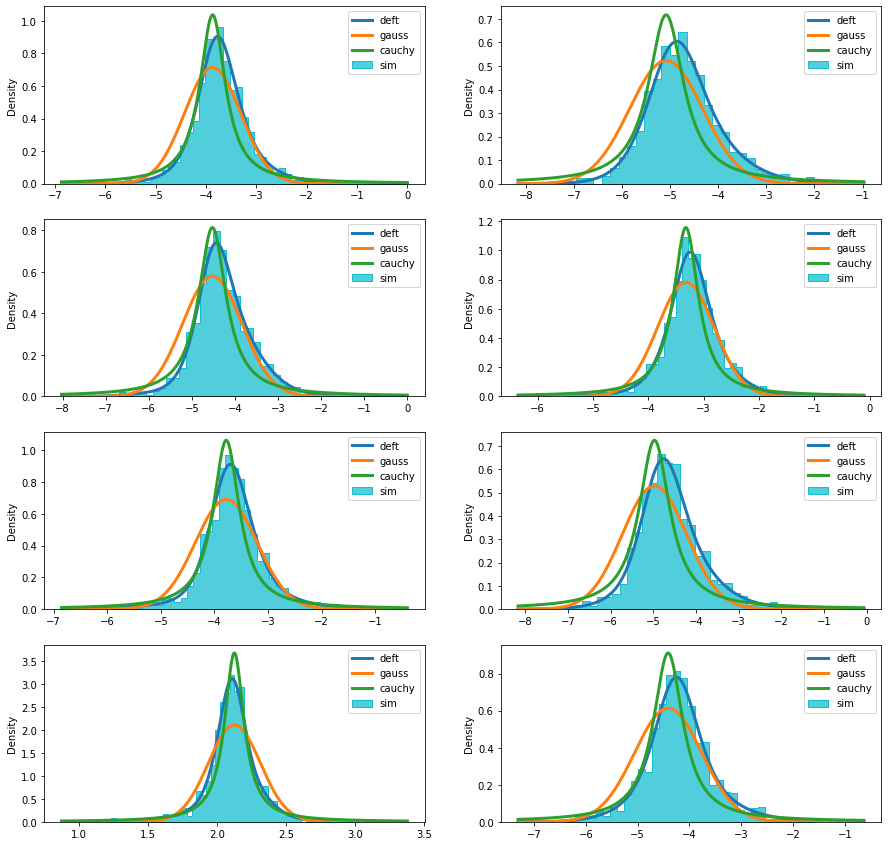

In [10]:
# Compute cauchy and gaussian distributions
from scipy.stats import norm, cauchy

linewidth=3
fig, axs = plt.subplots(4,2,figsize=[15,15])

for n, ax in enumerate(axs.ravel()):
    # Visualize marginals at selected n
    y_k = y_nk[n,:]
    
    # Show histogram
    sns.histplot(y_k, stat="density", ax=ax, element="step", color='C9', label='sim')
    
    # Estaimte and plot DEFT fit
    est = suftware.DensityEstimator(y_k, num_posterior_samples=0)
    y_lim = est.bounding_box
    y_grid = np.linspace(y_lim[0], y_lim[1], 1000)
    ax.plot(y_grid, est.evaluate(y_grid), label='deft', linewidth=linewidth)
    
    # Plot Gaussian fit
    f_gauss = norm(loc=y_n[n], scale=np.sqrt(dy2_n[n])).pdf
    ax.plot(y_grid, f_gauss(y_grid), label='gauss', linewidth=linewidth)
    
    # Plot Cauchy fit
    f_cauchy = cauchy(loc=y_n[n], scale=gamma_n[n]).pdf
    ax.plot(y_grid, f_cauchy(y_grid), label='cauchy', linewidth=linewidth)
    
    ax.legend()  

H[y] (deft): 2.1600 +- 0.0162 bits


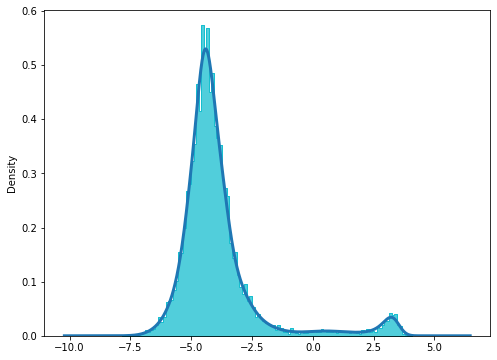

In [11]:
# Use DEFT to estimate entropy of full dataset
y = y_n.copy()

linewidth=3
fig, ax = plt.subplots(1,1,figsize=[8,6])

# Show histogram
sns.histplot(y, stat="density", ax=ax, element="step", color='C9', label='sim')

# Estaimte and plot DEFT fit
est = suftware.DensityEstimator(y, num_posterior_samples=100)
y_lim = est.bounding_box
y_grid = np.linspace(y_lim[0], y_lim[1], 1000)
ax.plot(y_grid, est.evaluate(y_grid), label='deft', linewidth=linewidth)

# Compute entropy of dataset using DEFT
stats = est.get_stats()
H_y_deft = stats.loc['posterior mean', 'entropy']
dH_y_deft = stats.loc['posterior RMSD', 'entropy']
print(f'H[y] (deft): {H_y_deft:.4f} +- {dH_y_deft:.4f} bits')

In [12]:
# Compute entropy of dataset using knn
y = y_n.copy()
y += np.std(y)*.01*np.random.randn(N_sub)
H_y_knn, dH_y_knn = entropy_continuous(y, knn=5, uncertainty=True, num_subsamples=100)
print(f'H[y] (knn): {H_y_knn:.4f} +- {dH_y_knn:.4f} bits')

H[y] (knn): 2.1474 +- 0.0147 bits


In [13]:
# Report mutual information values for various H_ygx estimates
for (name, H_ygx, dH_ygx) in [('naive', H_ygx_naive, dH_ygx_naive),
                              ('gauss', H_ygx_gauss, dH_ygx_gauss),
                              ('cauchy', H_ygx_cauchy, dH_ygx_cauchy),
                              ('knn',   H_ygx_knn,   dH_ygx_knn),
                              ('deft', H_ygx_deft, dH_ygx_deft)]:
    I_y_x = H_y_knn - H_ygx
    dI_y_x = np.sqrt(dH_y_knn**2 + dH_ygx**2)
    print(f'I_intr ({name}): {I_y_x:.4f} +- {dI_y_x:.4f} bits')
    
# Would be nice to see a plot of this

I_intr (naive): 0.9729 +- 0.0172 bits
I_intr (gauss): 0.8600 +- 0.0154 bits
I_intr (cauchy): 0.1318 +- 0.0157 bits
I_intr (knn): 0.9649 +- 0.0155 bits
I_intr (deft): 0.9176 +- 0.0319 bits


In [14]:
# Compute performance of additive model on dataset
# Remember, this is restricted to test set anyway
model = mavenn.load_example_model('gb1_ge_additive')

Model loaded from these files:
	../../mavenn/examples/models/gb1_ge_additive.pickle
	../../mavenn/examples/models/gb1_ge_additive.h5


In [15]:
I_pred, dI_pred = model.I_predictive(x=sub_df['x'], y=y_n)
print(f'I_pred (additive): {I_pred:.4f} +- {dI_pred:.4f} bits')

MavennError: x contain the following characters not in alphabet:{seq_chars-alphabet_chars}